# Lab 5. Minería de texto

## Miembros
- Fernanda Esquivel 21542
- Sofía Lam 21548

## Link al repositorio



In [1]:
import pandas as pd

In [3]:
test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')
df_original=pd.read_csv('sample_submission.csv')

In [4]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
test.columns

Index(['id', 'keyword', 'location', 'text'], dtype='object')

# Variables

Vemos que el dataset tiene 4 variables, el Id que es único para cada tweet. Un Keyword que básicamente hace un resumen de lo que habla el tweet. Location, la cuál nos dice la ubicación de dónde fue publicado el tweet sólo si se tiene activada la ubicación cuando se utiliza la aplicación. Y por último text que es el contenido del tweet.

In [6]:
null_key = test['keyword'].isna().sum()
null_key

26

De acá vemos que hay aproximadamente 26 datos que no tienen una keyword, entonces para no deshacernos de los datos, procedemos a rellenarlos con "no keyword"

In [7]:
test['keyword'] = test['keyword'].fillna('no keyword')
test['keyword'].isna().sum()

0

In [8]:
null_loc = test['location'].isna().sum()
null_loc

1105

De acá vemos que hay aún más datos sin la ubicación, esto puede deberse a que los usuarios prefieren mantener su ubicación fuera del alcance de la base de datos. Por lo que se procede a rellenar estas casillas con la frase "sin ubicación".

In [9]:
test['location'] = test['location'].fillna('sin ubicacion')
test['keyword'].isna().sum()

0

In [10]:
test.head()

,id,keyword,location,text
0,0,no keyword,sin ubicacion,Just happened a terrible car crash
1,2,no keyword,sin ubicacion,"Heard about #earthquake is different cities, s..."
2,3,no keyword,sin ubicacion,"there is a forest fire at spot pond, geese are..."
3,9,no keyword,sin ubicacion,Apocalypse lighting. #Spokane #wildfires
4,11,no keyword,sin ubicacion,Typhoon Soudelor kills 28 in China and Taiwan


Se crea la función que nos permite estandarizar el texto, de manera que se escribe todo el contenido del tweet en minusculas, se retiran los símbolos como "#" o "@". Se eliminan los URLs, los emoticones, los símbolos.

In [11]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')


def limpiar_texto(texto):

    texto = texto.lower()
    texto = re.sub(r"[#@']", "", texto)
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto, flags=re.MULTILINE)
    texto = texto.encode('ascii', 'ignore').decode('ascii')
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(texto)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]
    texto_limpio = ' '.join(tokens)
    return texto_limpio

test['texto_limpio'] = test['text'].apply(limpiar_texto)
test.head()
df_train['texto_limpio'] = df_train['text'].apply(limpiar_texto)
df_train.head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,keyword,location,text,target,texto_limpio
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


Para ver las diferentes keywords que hay en el data frame test


In [12]:
# Ver los valores únicos en la columna 'keyword'
unique_keywords = test['keyword'].unique()
print("Categorías únicas en 'keyword':")
print(unique_keywords)


Categorías únicas en 'keyword':
['no keyword' 'ablaze' 'accident' 'aftershock' 'airplane%20accident'
 'ambulance' 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army'
 'arson' 'arsonist' 'attack' 'attacked' 'avalanche' 'battle' 'bioterror'
 'bioterrorism' 'blaze' 'blazing' 'bleeding' 'blew%20up' 'blight'
 'blizzard' 'blood' 'bloody' 'blown%20up' 'body%20bag' 'body%20bagging'
 'body%20bags' 'bomb' 'bombed' 'bombing' 'bridge%20collapse'
 'buildings%20burning' 'buildings%20on%20fire' 'burned' 'burning'
 'burning%20buildings' 'bush%20fires' 'casualties' 'casualty'
 'catastrophe' 'catastrophic' 'chemical%20emergency' 'cliff%20fall'
 'collapse' 'collapsed' 'collide' 'collided' 'collision' 'crash' 'crashed'
 'crush' 'crushed' 'curfew' 'cyclone' 'damage' 'danger' 'dead' 'death'
 'deaths' 'debris' 'deluge' 'deluged' 'demolish' 'demolished' 'demolition'
 'derail' 'derailed' 'derailment' 'desolate' 'desolation' 'destroy'
 'destroyed' 'destruction' 'detonate' 'detonation' 'devastated'
 'd

Como podemos ver, el data frame solo cuenta con 4 columnas en las cuáles no está incluido si es o no es un desastre natural. Entonces, agregamos esta columna con las palabras que corresponden a un desastre. Por lo que se crea una lista de palabras clave para buscarlas en el texto ya limpio

In [13]:
desastre = ['earthquake', 'forest fire', 'hurricane', 'flood', 'tsunami', 'tornado', 'wildfire', 'eruption']

# Función para verificar si un texto contiene alguna de las palabras clave
def es_desastre(texto_limpio):
    return 1 if any(keyword in texto_limpio for keyword in desastre) else 0

# Crear una nueva columna 'disaster_related' que indica si el tweet es sobre un desastre natural
test['Target'] = test['texto_limpio'].apply(es_desastre)


In [14]:
test.head()

,id,keyword,location,text,texto_limpio,Target
0,0,no keyword,sin ubicacion,Just happened a terrible car crash,happened terrible car crash,0
1,2,no keyword,sin ubicacion,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...,1
2,3,no keyword,sin ubicacion,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...,1
3,9,no keyword,sin ubicacion,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,1
4,11,no keyword,sin ubicacion,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 china taiwan,0


Ahora se separan aquellos tweets que están relacionados con desastres naturales de los que no


In [15]:
tweets_desastre = test[test['Target'] == 1]['texto_limpio']
tweets_no_desastre = test[test['Target'] == 0]['texto_limpio']


Ahora se tokeniza la columna de texto limpio para poder analizar la frecuencia de cada palabra y posteriormente realizar los bigramas, trigramas y las gráficas para el análisis correspondiente

In [16]:
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

nltk.download('punkt')
def contar_frecuencia(tweets):
    todas_las_palabras = ' '.join(tweets).lower()
    tokens = word_tokenize(todas_las_palabras)
    frecuencias = Counter(tokens)
    return frecuencias

frecuencia_desastre = contar_frecuencia(tweets_desastre)
frecuencia_no_desastre = contar_frecuencia(tweets_no_desastre)
print("Palabras más comunes en tweets de desastre:")
print(frecuencia_desastre.most_common(10))
print("\nPalabras más comunes en tweets que no son de desastre:")
print(frecuencia_no_desastre.most_common(10))


Palabras más comunes en tweets de desastre:
[('flood', 27), ('wildfire', 27), ('floods', 22), ('earthquake', 21), ('california', 21), ('hurricane', 17), ('forest', 15), ('northern', 14), ('tsunami', 14), ('flooding', 13)]

Palabras más comunes en tweets que no son de desastre:
[('like', 135), ('amp', 124), ('im', 122), ('get', 101), ('fire', 99), ('via', 99), ('new', 91), ('one', 82), ('news', 77), ('people', 77)]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
# Palabra más repetida en tweets de desastre
palabra_mas_comun_desastre = frecuencia_desastre.most_common(1)
print(f"Palabra más repetida en tweets de desastre: {palabra_mas_comun_desastre}")

# Palabra más repetida en tweets que no son de desastre
palabra_mas_comun_no_desastre = frecuencia_no_desastre.most_common(1)
print(f"Palabra más repetida en tweets que no son de desastre: {palabra_mas_comun_no_desastre}")


Palabra más repetida en tweets de desastre: [('flood', 27)]
Palabra más repetida en tweets que no son de desastre: [('like', 135)]


Como vemos anteriormente, la palbra más común para aquellos tweets sobre desastres es "flood". Mientras que para aquellos tweets que no hablan de un desastre la palabra más común es "like".

# Bigramas y Trigramas
Ahora bien, realizamos los bigramas y trigramas para poder analizar aquellas palabras que tienden a ir juntas en los tweets.

In [18]:
from nltk import bigrams, trigrams

# Función para contar la frecuencia de bigramas
def contar_bigramas(tweets):
    todas_las_palabras = ' '.join(tweets).lower()
    tokens = word_tokenize(todas_las_palabras)
    bigrama_frecuencia = Counter(bigrams(tokens))
    return bigrama_frecuencia

# Función para contar la frecuencia de trigramas
def contar_trigramas(tweets):
    todas_las_palabras = ' '.join(tweets).lower()
    tokens = word_tokenize(todas_las_palabras)
    trigrama_frecuencia = Counter(trigrams(tokens))
    return trigrama_frecuencia

# Obtener frecuencias de bigramas y trigramas para tweets de desastre
bigramas_desastre = contar_bigramas(tweets_desastre)
trigramas_desastre = contar_trigramas(tweets_desastre)

print("\nBigramas más comunes en tweets de desastre:")
print(bigramas_desastre.most_common(10))

print("\nTrigramas más comunes en tweets de desastre:")
print(trigramas_desastre.most_common(10))



Bigramas más comunes en tweets de desastre:
[(('northern', 'california'), 13), (('california', 'wildfire'), 12), (('latest', 'homes'), 11), (('homes', 'razed'), 11), (('razed', 'northern'), 11), (('forest', 'fires'), 10), (('cree', 'led'), 8), (('led', 'work'), 8), (('work', 'light'), 8), (('abc', 'news'), 7)]

Trigramas más comunes en tweets de desastre:
[(('northern', 'california', 'wildfire'), 12), (('latest', 'homes', 'razed'), 11), (('homes', 'razed', 'northern'), 11), (('razed', 'northern', 'california'), 11), (('cree', 'led', 'work'), 8), (('led', 'work', 'light'), 8), (('california', 'wildfire', 'abc'), 6), (('wildfire', 'abc', 'news'), 6), (('spot', 'flood', 'combo'), 5), (('work', 'light', 'bar'), 5)]


De esto podemos ver que el bigrama más común en los tweets de desastre es "(northern, California)"y el trigrama más común para estos mismos tweets es "(Northern, California, wildfire)"

# Nube de palabras
Ahora se crea una nube de palabras sobre cada tweet según su categoría

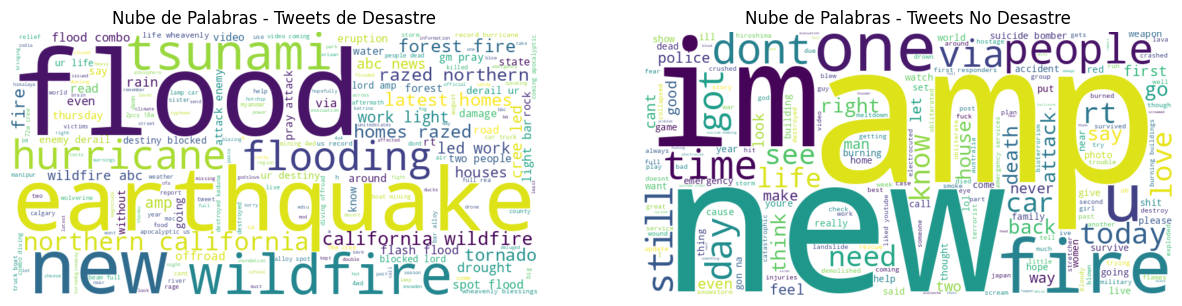

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud_desastre = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tweets_desastre))
wordcloud_no_desastre = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tweets_no_desastre))
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_desastre, interpolation='bilinear')
plt.title('Nube de Palabras - Tweets de Desastre')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_no_desastre, interpolation='bilinear')
plt.title('Nube de Palabras - Tweets No Desastre')
plt.axis('off')
plt.show()


# Histogramas
Ahora realizamos los histogramas con las palbras más repetidas según los distintos tweets

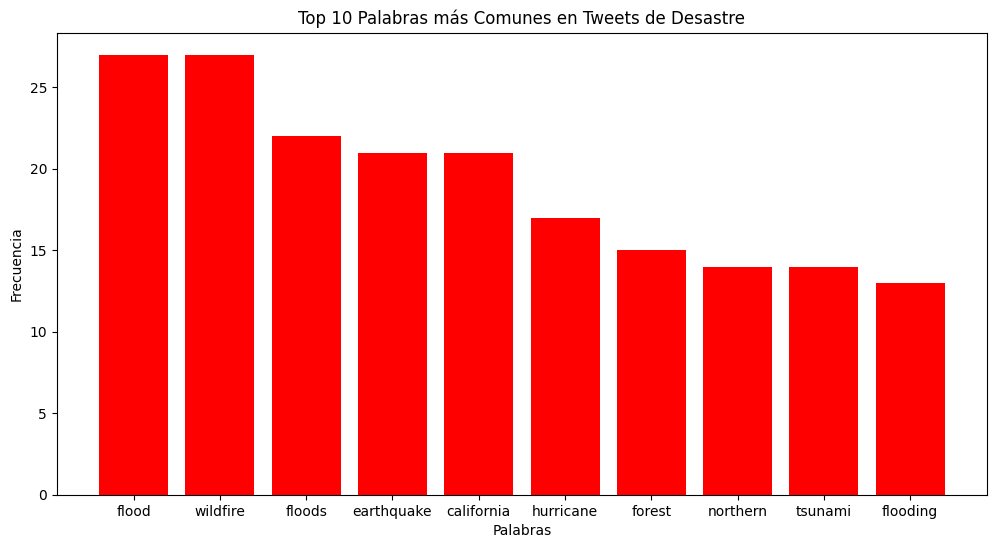

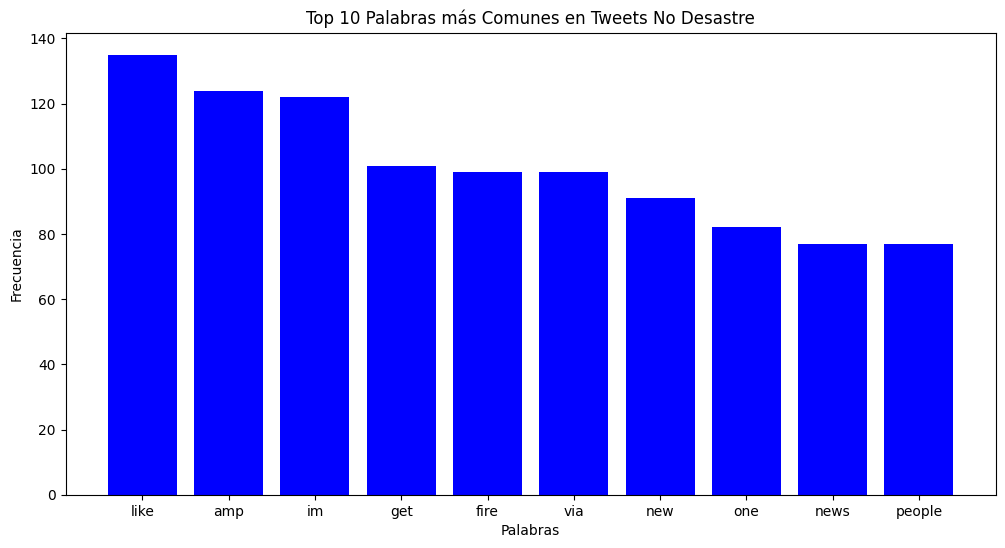

In [20]:
frecuencias_desastre_top10 = frecuencia_desastre.most_common(10)
palabras_desastre, conteos_desastre = zip(*frecuencias_desastre_top10)
plt.figure(figsize=(12, 6))
plt.bar(palabras_desastre, conteos_desastre, color='red')
plt.title('Top 10 Palabras más Comunes en Tweets de Desastre')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.show()

frecuencias_no_desastre_top10 = frecuencia_no_desastre.most_common(10)
palabras_no_desastre, conteos_no_desastre = zip(*frecuencias_no_desastre_top10)
plt.figure(figsize=(12, 6))
plt.bar(palabras_no_desastre, conteos_no_desastre, color='blue')
plt.title('Top 10 Palabras más Comunes en Tweets No Desastre')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.show()


Ahora buscamos aquellas palabras que son comunes en ambas categorías

In [21]:
palabras_comunes = set(frecuencia_desastre.keys()).intersection(set(frecuencia_no_desastre.keys()))
print("Palabras comunes en ambas categorías:")
print(palabras_comunes)



Palabras comunes en ambas categorías:
{'school', 'download', 'couldnt', 'hunting', 'fire', 'think', 'stay', 'hardest', 'sing', 'net', 'cree', 'hopefully', 'borders', 'stick', 'currently', 'going', 'wan', 'bbc', 'rock', 'let', 'goddamn', 'understand', 'washed', 'areas', 'kisses', 'matter', 'street', 'information', 'shark', 'record', 'helps', 'reports', 'shot', 'love', 'see', 'massive', 'may', 'hit', 'southern', '26', 'anchorage', 'caused', 'tried', 'american', '60', 'drone', 'lets', 'apartments', 'climate', 'financial', 'thursday', 'sept', 'grows', 'past', 'fl', 'evacuated', 'solid', 'oregon', 'car', 'w', 'sisters', 'columbia', 'brewing', 'global', 'ya', 'homes', 'ocean', 'heres', 'natural', 'hold', 'great', 'three', 'undo', 'terri', 'responding', 'hrs', 'violent', 'happened', 'last', '5', 'attack', '200', 'approaches', 'apocalyptic', 'kept', 'decide', 'say', 'articles', 'one', 'wouldnt', 'breaks', 'cheese', 'failed', 'please', 'titanic', 'read', 'weather', 'service', 'oaks', 'ur', 'mon

ahora se toman en cuenta los otros conjuntos de datos para poder entrenar los modelos que se van a realizar.

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1, 2))

X_train_tfidf = tfidf.fit_transform(df_train['texto_limpio'])
X_test_tfidf = tfidf.transform(test['texto_limpio'])

y_train = df_train['target']
y_test = test['Target']


# Modelo regresión Logística

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

log_reg = LogisticRegression()
log_reg.fit(X_train_tfidf, y_train)

y_pred_log_reg = log_reg.predict(X_test_tfidf)

print("Regresión Logística")
print(classification_report(y_test, y_pred_log_reg))
print(confusion_matrix(y_test, y_pred_log_reg))


Regresión Logística
              precision    recall  f1-score   support

           0       0.97      0.69      0.80      3091
           1       0.10      0.63      0.17       172

    accuracy                           0.68      3263
   macro avg       0.54      0.66      0.49      3263
weighted avg       0.92      0.68      0.77      3263

[[2118  973]
 [  64  108]]


De esto podemos ver que tenemos un modelo con una precisión aproximada de 97%, sin embargo más adelante se pondrán a prueba otros modelos para ver cuál es más adecuado y se tomaran en cuenta redes neuronales.

# SVM
Ahora se prueba con modelo SVM

In [41]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X_train_tfidf, y_train)

y_pred_svm = svm.predict(X_test_tfidf)
print("SVM")
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))


SVM
              precision    recall  f1-score   support

           0       0.97      0.65      0.78      3091
           1       0.10      0.70      0.17       172

    accuracy                           0.65      3263
   macro avg       0.54      0.67      0.48      3263
weighted avg       0.93      0.65      0.75      3263

[[2010 1081]
 [  52  120]]


# Random Forest
Un modelo random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)

y_pred_rf = rf.predict(X_test_tfidf)
print("Random Forest")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


Random Forest
              precision    recall  f1-score   support

           0       0.98      0.69      0.81      3091
           1       0.11      0.69      0.19       172

    accuracy                           0.69      3263
   macro avg       0.54      0.69      0.50      3263
weighted avg       0.93      0.69      0.77      3263

[[2123  968]
 [  53  119]]


#Red Neuronal

In [43]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(30, 30, 30), max_iter=500)
mlp.fit(X_train_tfidf, y_train)


y_pred_mlp = mlp.predict(X_test_tfidf)
print("Neural Network")
print(classification_report(y_test, y_pred_mlp))
print(confusion_matrix(y_test, y_pred_mlp))


Neural Network
              precision    recall  f1-score   support

           0       0.97      0.64      0.77      3091
           1       0.09      0.66      0.16       172

    accuracy                           0.64      3263
   macro avg       0.53      0.65      0.47      3263
weighted avg       0.92      0.64      0.74      3263

[[1977 1114]
 [  59  113]]


Después de analizar todos los modelos, podemos ver que el Random Forest parece ser el mejor modelo en términos generales, pues este tiene una mayor exactitud y un buen equilibrio entre precisión y recall para la clase 0.

Sin embargo, es importante mencionar que todos los modelos muestran un rendimiento relativamente bajo en la clase 1, lo que nos dice que hay un desbalance en las clases.